In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv("../data/drafted_cleaned.csv")

# Usiamo solo giocatori con WS calcolabile
df = df[df["WS"] != -100].copy()

df.head()


,DraftYear,Pick,Tm,Player,College,Seasons,Games,MP,PTS,TRB,...,WS_available,WS/48_available,BPM_available,VORP_available,MP_available,TRB_available,FG%_available,FT%_available,MP.1_available,TRB.1_available
0,1947,1.0,PIT,Clifton McNeely,Texas Wesleyan University,0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
1,1947,2.0,TRH,Glen Selbo,Wisconsin,1,13.0,-100.0,42.0,-100.0,...,1,0,0,0,0,0,1,1,0,0
2,1947,3.0,BOS,Bulbs Ehlers,Purdue,2,99.0,-100.0,800.0,-100.0,...,1,0,0,0,0,0,1,1,0,0
3,1947,4.0,PRO,Walt Dropo,UConn,0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
4,1947,5.0,NYK,Dick Holub,Long Island University,1,48.0,-100.0,504.0,-100.0,...,1,0,0,0,0,0,1,1,0,0


In [2]:
#Selezione delle colonne utili
features = ["Player","Pick", "PickBand", "DraftYear", "College"]
target = "WS"

df_model = df[features + [target]].copy()

df_model.isna().sum()


Player       0
Pick         0
PickBand     0
DraftYear    0
College      0
WS           0
dtype: int64

In [3]:
X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

len(X_train), len(X_test)

(5826, 2497)

In [4]:
categorical = ["PickBand", "College"]
numeric = ["Pick", "DraftYear"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numeric)
    ]
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", RandomForestRegressor(
        n_estimators=300,
        max_depth=12,
        random_state=42
    ))
])

model


,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [5]:
#Addestramento 
model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [6]:
# 7. Predizione + metriche (qui NON ci devono più essere mismatch)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)


print("MAE:", mae)
print("RMSE:", rmse)

# 8. Costruisco il DataFrame per Expected WS e Delta
df_test_pred = X_test.copy()
df_test_pred["WS"] = y_test.values
df_test_pred["Expected_WS"] = y_pred
df_test_pred["Delta"] = df_test_pred["WS"] - df_test_pred["Expected_WS"]

df_test_sorted = df_test_pred.sort_values("Delta", ascending=False)
df_test_sorted.head()

df_test["Expected_WS"] = y_pred
df_test["Delta"] = df_test["WS"] - df_test["Expected_WS"]

df_test_sorted = df_test.sort_values("Delta", ascending=False)
df_test_sorted.head()


MAE: 7.55100159189737
RMSE: 17.178203112512445


NameError: name 'df_test' is not defined

In [17]:
#Overperform top 10
overperformer = df_test_sorted.head(10)
overperformer[["Player","Pick", "College", "WS", "Expected_WS", "Delta"]]


,Player,Pick,College,WS,Expected_WS,Delta
7710,Nikola Jokić,41.0,Overseas (Serbia),126.0,6.307182,119.692818
7519,Jimmy Butler,30.0,Marquette,121.3,13.017612,108.282388
7624,Giannis Antetokounmpo,15.0,Overseas (Greece),118.7,18.714815,99.985185
7555,Damian Lillard,6.0,Weber State,118.6,30.549379,88.050621
7636,Rudy Gobert,27.0,Overseas (France),114.2,28.403751,85.796249
7504,Kawhi Leonard,15.0,San Diego State,101.2,23.321545,77.878455
7550,Anthony Davis,1.0,Kentucky,118.6,47.724169,70.875831
7505,Nikola Vučević,16.0,USC,78.8,19.404300,59.395700
7508,Tobias Harris,19.0,Tennessee,75.1,17.974376,57.125624
7584,Draymond Green,35.0,Michigan State,64.2,7.276205,56.923795


In [18]:
#Underperform Top 10
underperformer = df_test_sorted.tail(10)
underperformer[["Player","Pick", "College", "WS", "Expected_WS", "Delta"]]



,Player,Pick,College,WS,Expected_WS,Delta
7990,Brandon Clarke,21.0,Gonzaga,24.6,66.052356,-41.452356
7793,Dragan Bender,4.0,Overseas (Bosnia & Herzegovina),0.5,42.399978,-41.899978
8031,LaMelo Ball,3.0,High School,13.6,55.544618,-41.944618
7554,Thomas Robinson,5.0,Kansas,4.6,47.585356,-42.985356
7790,Ben Simmons,1.0,LSU,35.4,80.217568,-44.817568
7610,Anthony Bennett,1.0,UNLV,0.5,47.122454,-46.622454
7851,Lonzo Ball,2.0,UCLA,12.6,59.607822,-47.007822
7853,Josh Jackson,4.0,Kansas,-1.7,46.510764,-48.210764
8033,Isaac Okoro,5.0,Auburn,15.4,66.015058,-50.615058
7493,Tristan Thompson,4.0,Texas,49.3,101.582207,-52.282207


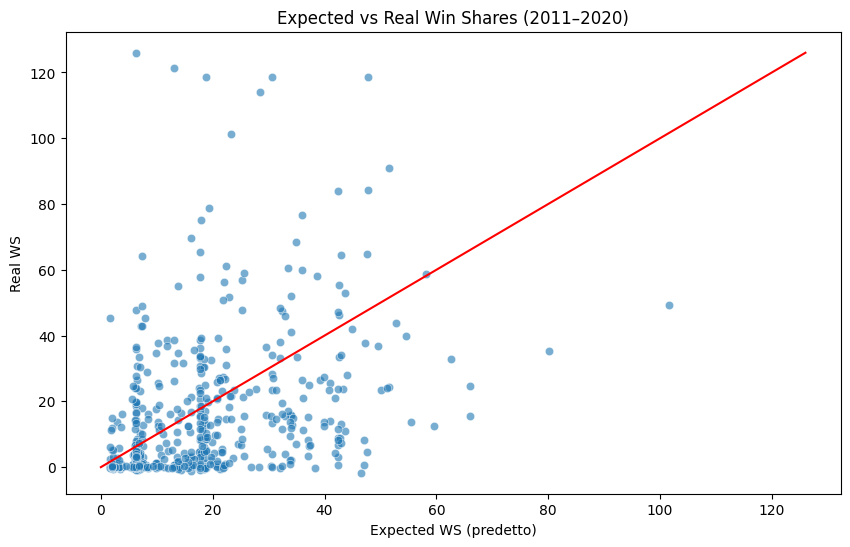

In [19]:
#Scatter plot Reale vs Atteso

plt.figure(figsize=(10,6))
sns.scatterplot(x=df_test["Expected_WS"], y=df_test["WS"], alpha=0.6)
plt.plot([0, max(y_test)], [0, max(y_test)], color="red")  # linea ideale
plt.xlabel("Expected WS (predetto)")
plt.ylabel("Real WS")
plt.title("Expected vs Real Win Shares (2011–2020)")
plt.show()

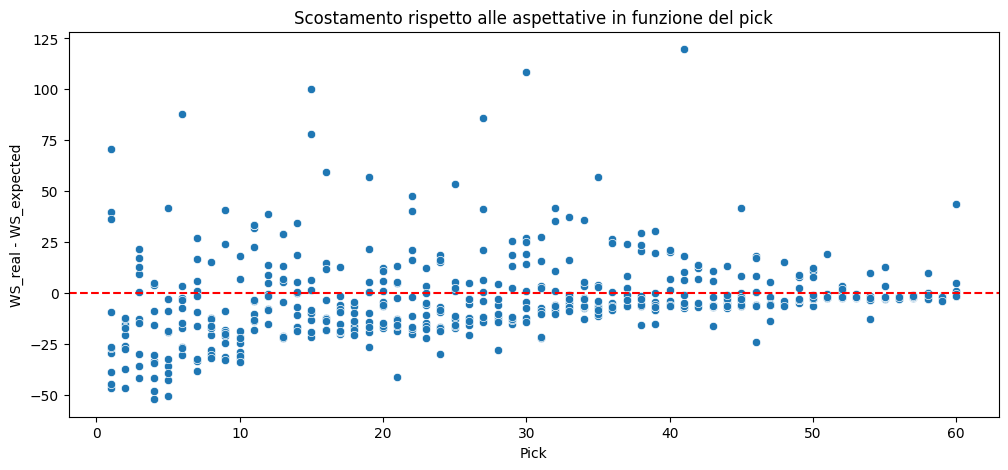

In [20]:
#Residui per il pick 
plt.figure(figsize=(12,5))
sns.scatterplot(x=df_test["Pick"], y=df_test["Delta"])
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Pick")
plt.ylabel("WS_real - WS_expected")
plt.title("Scostamento rispetto alle aspettative in funzione del pick")
plt.show()
